### **首先明确一点，pooling经过大佬的更正叫汇聚，以前叫池化**

## 明确一个q,k,v观点：
* q是qurey,代表的是推理计算的输入
* k是keys，代表的是训练数据的输入x
* v是values，代表的是训练数据的输出y 


In [1]:
import torch 
from d2l import torch as d2l
from torch import nn 

In [23]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 训练样本的输入
#torch.sort在默认情况下从小到大排序
def f( x ):
    return 2*torch.sin( x ) + x**0.8
y_train = f( x_train ) + torch.normal( 0.0 , 0.5 ,  ( n_train , ) )#加入一点噪音
x_test = torch.arange( 0 , 5 , 0.1 )
y_truth = f( x_test ) #测试样本的真实输入
n_test = len( x_test )


In [24]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

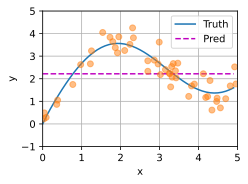

In [25]:
y_hat = torch.repeat_interleave( y_train.mean() , n_test )#采用平均汇聚，将y_train的平均值复制50个
plot_kernel_reg( y_hat)

In [26]:
x_repeat  = x_test.repeat_interleave( n_train ).reshape( -1 , n_train )#torch.Size([50, 50]),每一行都包含一样的查询x

In [27]:
x_repeat - x_train#这里实际上用到了广播机制，x_train的长度本来就是(50),对x_train进行了扩充

tensor([[-0.0297, -0.0430, -0.0902,  ..., -4.8145, -4.9273, -4.9606],
        [ 0.0703,  0.0570,  0.0098,  ..., -4.7145, -4.8273, -4.8606],
        [ 0.1703,  0.1570,  0.1098,  ..., -4.6145, -4.7273, -4.7606],
        ...,
        [ 4.6703,  4.6570,  4.6098,  ..., -0.1145, -0.2273, -0.2606],
        [ 4.7703,  4.7570,  4.7098,  ..., -0.0145, -0.1273, -0.1606],
        [ 4.8703,  4.8570,  4.8098,  ...,  0.0855, -0.0273, -0.0606]])

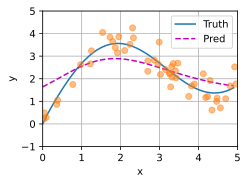

In [28]:
attention_weight = nn.functional.softmax( -( x_repeat - x_train )**2 / 2 , dim= 1  )#dim=1就是按行计算
y_hat = torch.matmul( attention_weight ,  y_train )
plot_kernel_reg( y_hat )

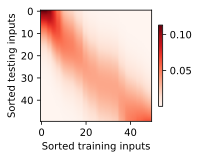

In [29]:
d2l.show_heatmaps(attention_weight.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')


## 带参数注意力汇聚

In [30]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm( X ,Y ).shape#批量矩阵乘法

torch.Size([2, 1, 6])

In [31]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
#将weights转化为( 2 ,1 ,10 ) ----> weights.unsqueeze( 1 ) , 将values转化为( 2 , 10 , 1 ),这样的话torch.bmm就得到了批次相乘
torch.bmm( weights.unsqueeze( 1 ) , values.unsqueeze( -1 ) )

tensor([[[ 4.5000]],

        [[14.5000]]])

## 定义模型 --- 带参数注意力汇聚

In [32]:
class NWKernelRegression( nn.Module ):
    def __init__( self,  **kwargs):
        super().__init__( **kwargs )
        self.w = nn.Parameter( torch.rand( (1,) )  , requires_grad= True )

    def forward( self , queires , keys , values ):
        queires = queires.repeat_interleave( keys.shape[1] ).reshape( (  -1 , keys.shape[1] ) )
        self.attention_weight = nn.functional.softmax(  
            -( ( queires - keys ) * self.w )**2/2 , dim = 1 )
        return torch.bmm( self.attention_weight.unsqueeze( 1 ) , 
                          values.unsqueeze( -1 ) ).reshape( -1 )#将元素展开,按本例程来讲就是将( 50 ,1 ,1 )转换为( 50 )

In [33]:
# `X_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
#Y_title的形状：( n_train ,  n_train ) , 每一行都包含相同的训练输出
Y_tile = y_train.repeat( ( n_train , 1  ) )
#keys进行对x_train进行提取，key的形状是 ( n_train , n_train-1 ) ,本例子为( 50 ,49 )
keys = X_tile[ ( 1 - torch.eye( n_train ) ).type( torch.bool ) ].reshape( ( n_train , -1 ) )
#values的形状也是( n_train , n_train-1 ) , 本例子为( 50 , 49 )
values = Y_tile[  ( 1 - torch.eye( n_train )).type( torch.bool ) ].reshape( ( n_train , -1 ) )

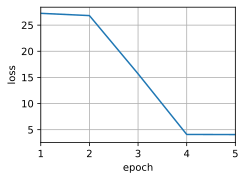

In [42]:
net = NWKernelRegression(  )
loss = nn.MSELoss( reduction='none' )
trainer = torch.optim.SGD( net.parameters() , lr=0.1 )
animator = d2l.Animator( xlabel='epoch'  , ylabel= 'loss' , xlim=[1,5] )

for epoch in range( 20 ):
    trainer.zero_grad()
    y_hat = net( x_train , keys , values )  #torch.size( 50 )
    # print( y_hat.shape )
    l = loss( y_hat , y_train ) / 2
    l.sum().backward()
    trainer.step()
    print( f'epoch:{epoch + 1 } , loss:{float( l.sum() ):.3f}' )
    animator.add( epoch+1 , float( l.sum() ) )

In [35]:
test_x = torch.ones( 2 , 1 , 2 )
test_y = torch.ones( 2 , 2 , 1 )
torch.bmm( test_x , test_y).shape

torch.Size([2, 1, 1])

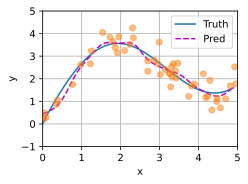

In [43]:
# `keys` 的形状: (`n_test`, `n_train`), 每一行包含着相同的训练输入（例如：相同的键）
keys = x_train.repeat((n_test, 1))
# `value` 的形状: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)


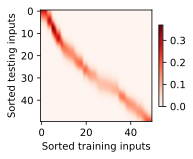

In [45]:
d2l.show_heatmaps(net.attention_weight.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')
